In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA


In [2]:
# Load and prepare data
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')


In [3]:
# Create customer features
# Transaction-based features
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean']
}).fillna(0)


In [4]:
# Flatten column names
customer_transactions.columns = ['_'.join(col).strip() for col in customer_transactions.columns.values]


In [5]:
# Merge with customer profile data
customer_features = customers.merge(
    customer_transactions, 
    left_on='CustomerID', 
    right_index=True,
    how='left'
)


In [6]:
# Select features for clustering
features_for_clustering = [
    'TransactionID_count',
    'TotalValue_sum', 'TotalValue_mean',
    'Quantity_sum', 'Quantity_mean'
]

X = customer_features[features_for_clustering]



In [8]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_scaled = imputer.fit_transform(X_scaled)


In [10]:
import pandas as pd
X_scaled = pd.DataFrame(X_scaled)
X_scaled = X_scaled.dropna()
X_scaled = X_scaled.values  # Convert back to NumPy array if needed


In [11]:
# Find optimal number of clusters using elbow method and DB Index
db_scores = []
silhouette_scores = []
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    inertias.append(kmeans.inertia_)


c:\Users\Bala cheran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bala cheran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bala cheran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bala cheran\AppData\Local\Programs\Python\Python311\Lib\si

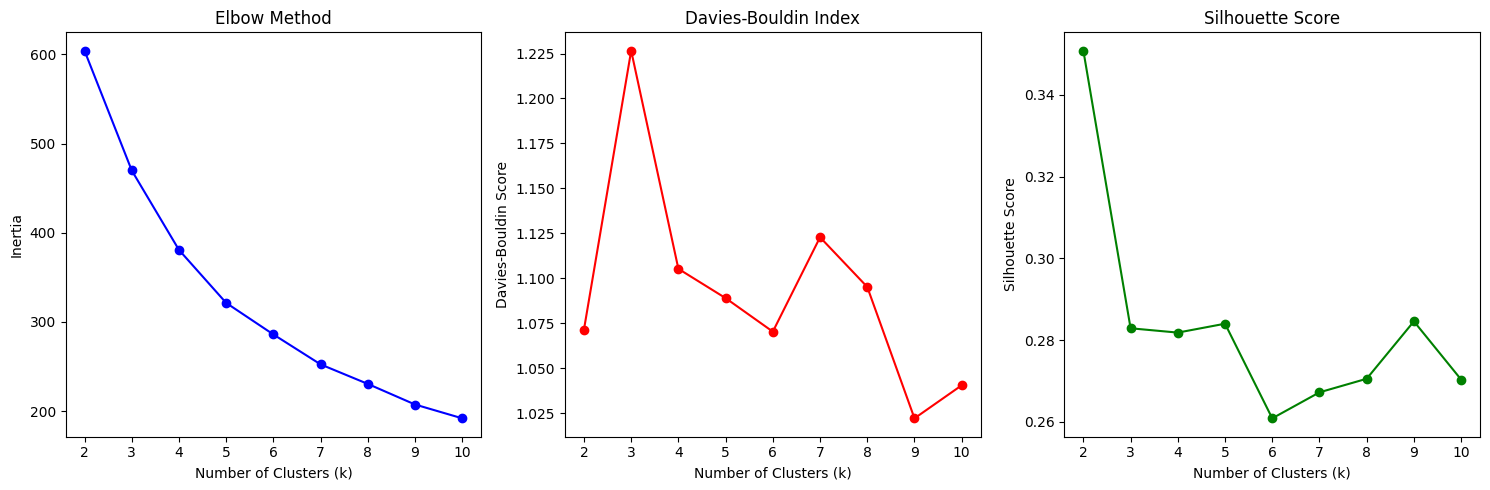

In [12]:
# Plot evaluation metrics
plt.figure(figsize=(15, 5))

# Elbow curve
plt.subplot(131)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Davies-Bouldin scores
plt.subplot(132)
plt.plot(k_range, db_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Index')

# Silhouette scores
plt.subplot(133)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

In [13]:
# Select optimal k based on DB Index
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")
print(f"Best DB Index score: {min(db_scores):.4f}")
print(f"Best Silhouette score: {max(silhouette_scores):.4f}")

Optimal number of clusters based on DB Index: 9
Best DB Index score: 1.0221
Best Silhouette score: 0.3508


In [14]:
# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(X_scaled)

c:\Users\Bala cheran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


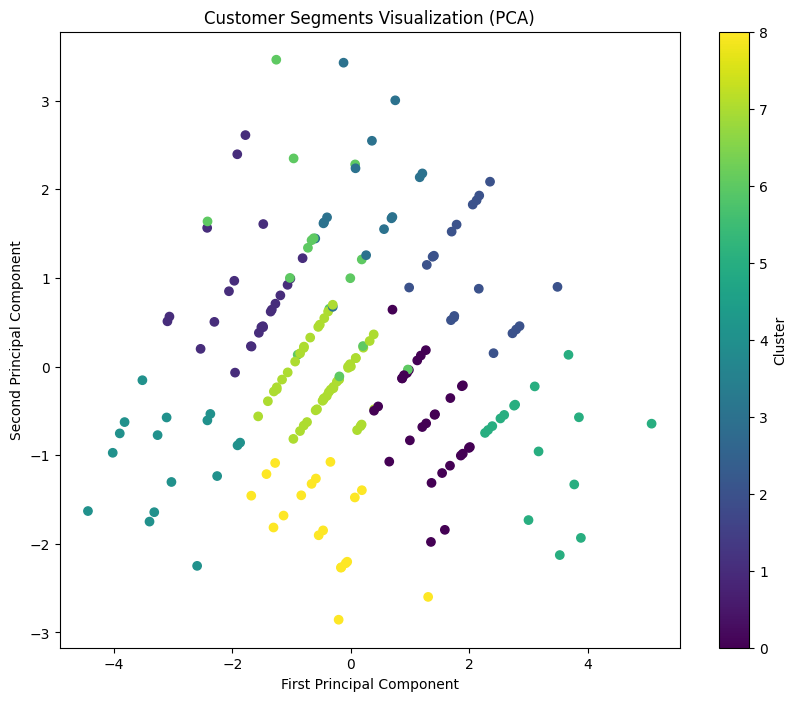

In [15]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create cluster visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=customer_features['Cluster'], 
                     cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [16]:
# Analyze cluster characteristics
cluster_profiles = customer_features.groupby('Cluster')[features_for_clustering].mean()
print("\nCluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
         TransactionID_count  TotalValue_sum  TotalValue_mean  Quantity_sum  \
Cluster                                                                       
0                   6.965517     4931.240000       717.085599     17.379310   
1                   2.375000     1657.325000       715.891111      5.750000   
2                   5.736842     5486.414737       964.904865     18.684211   
3                   3.400000     3736.682667      1108.354000      9.800000   
4                   2.562500      742.274375       280.302312      4.375000   
5                   8.875000     6875.244375       782.190739     24.750000   
6                   3.400000     2101.494667       634.327333     11.133333   
7                   4.717391     2961.490000       628.338373     11.413043   
8                   6.842105     3015.285263       446.037936     12.368421   

         Quantity_mean  
Cluster                 
0             2.507882  
1             2.409722  
2          

In [17]:
# Create radar chart for cluster profiles
def radar_chart(cluster_profiles):
    # Normalize the cluster profiles for radar chart
    normalized_profiles = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())
    
    # Set up the radar chart
    categories = features_for_clustering
    n_categories = len(categories)
    angles = [n / float(n_categories) * 2 * np.pi for n in range(n_categories)]
    angles += angles[:1]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for cluster in normalized_profiles.index:
        values = normalized_profiles.loc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    # Set chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], categories, rotation=45)
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Characteristics Comparison")
    plt.show()

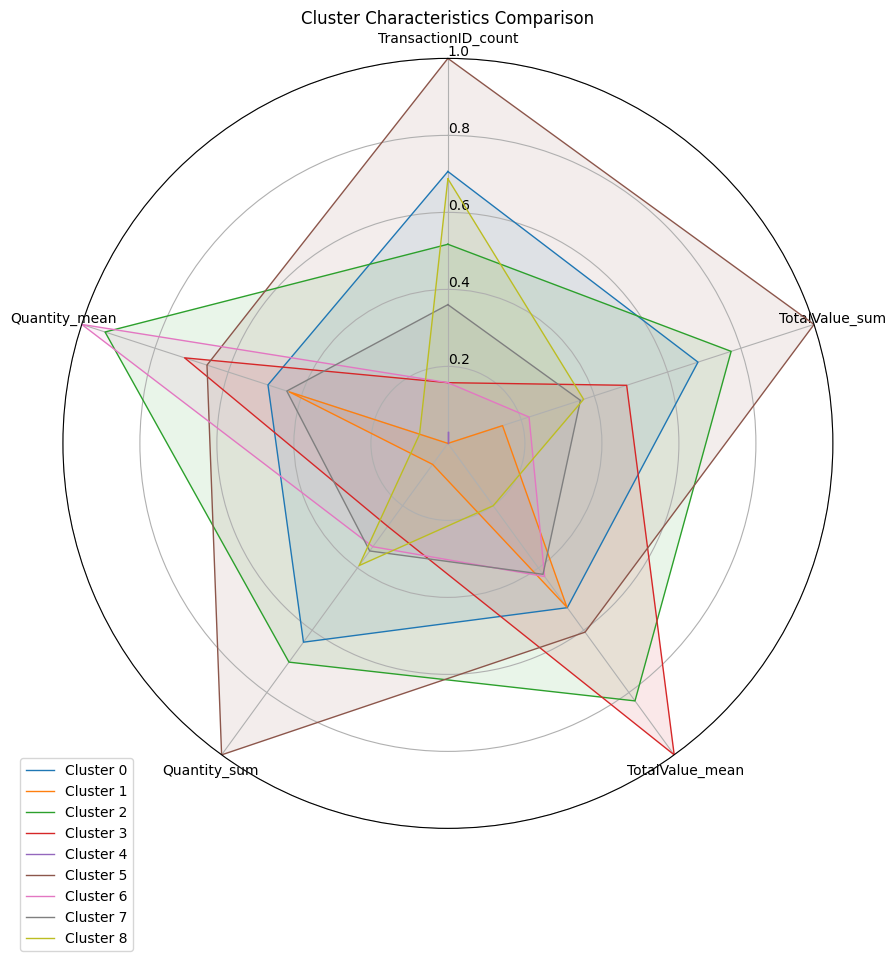

In [18]:
radar_chart(cluster_profiles)

# Save results
results_df = customer_features[['CustomerID', 'Cluster']]
results_df.to_csv('customer_segments.csv', index=False)

In [19]:
# Select optimal k based on DB Index
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")
print(f"Best DB Index score: {min(db_scores):.4f}")
print(f"Best Silhouette score: {max(silhouette_scores):.4f}")

Optimal number of clusters based on DB Index: 9
Best DB Index score: 1.0221
Best Silhouette score: 0.3508
